In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from skimage import color
from skimage import io
from skimage.transform import rescale, resize
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.models import Sequential
import tensorflow as tf
import warnings

In [3]:
import os
f=[] 
def listdirs(rootdir):
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            print(d)
            f.append(d)
            listdirs(d)
 
rootdir = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
listdirs(rootdir)

../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca
../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc
../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n


In [4]:
import pandas as pd
from pathlib import Path

image_dir_path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpeg')]
df1 = pd.DataFrame(data=paths, columns=['Root', 'Type', 'Images'])
print(df1)


image_dir_path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpeg')]
df2 = pd.DataFrame(data=paths, columns=['Root', 'Type', 'Images'])
print(df2)
image_dir_path ='../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpeg')]
df3 = pd.DataFrame(data=paths, columns=['Root', 'Type', 'Images'])
print(df3)

                 Root    Type          Images
0     lung_image_sets  lung_n   lungn691.jpeg
1     lung_image_sets  lung_n  lungn3098.jpeg
2     lung_image_sets  lung_n  lungn4225.jpeg
3     lung_image_sets  lung_n    lungn40.jpeg
4     lung_image_sets  lung_n  lungn4213.jpeg
...               ...     ...             ...
4995  lung_image_sets  lung_n  lungn1469.jpeg
4996  lung_image_sets  lung_n  lungn1508.jpeg
4997  lung_image_sets  lung_n  lungn1966.jpeg
4998  lung_image_sets  lung_n  lungn4090.jpeg
4999  lung_image_sets  lung_n   lungn554.jpeg

[5000 rows x 3 columns]
                 Root      Type            Images
0     lung_image_sets  lung_scc  lungscc1930.jpeg
1     lung_image_sets  lung_scc  lungscc1441.jpeg
2     lung_image_sets  lung_scc  lungscc4624.jpeg
3     lung_image_sets  lung_scc  lungscc4038.jpeg
4     lung_image_sets  lung_scc  lungscc2504.jpeg
...               ...       ...               ...
4995  lung_image_sets  lung_scc  lungscc3958.jpeg
4996  lung_image_sets  

In [5]:
df = pd.concat([df1,df2,df3])
df.reset_index()

,index,Root,Type,Images
0,0,lung_image_sets,lung_n,lungn691.jpeg
1,1,lung_image_sets,lung_n,lungn3098.jpeg
2,2,lung_image_sets,lung_n,lungn4225.jpeg
3,3,lung_image_sets,lung_n,lungn40.jpeg
4,4,lung_image_sets,lung_n,lungn4213.jpeg
...,...,...,...,...
14995,4995,lung_image_sets,lung_aca,lungaca3823.jpeg
14996,4996,lung_image_sets,lung_aca,lungaca2457.jpeg
14997,4997,lung_image_sets,lung_aca,lungaca4147.jpeg
14998,4998,lung_image_sets,lung_aca,lungaca1477.jpeg


In [6]:
import os
os.makedirs('/kaggle/working/cmyk/lung_n')
os.makedirs('/kaggle/working/cmyk/lung_scc')
os.makedirs('/kaggle/working/cmyk/lung_aca')
os.makedirs('/kaggle/working/ycbcr/lung_n')
os.makedirs('/kaggle/working/ycbcr/lung_scc')
os.makedirs('/kaggle/working/ycbcr/lung_aca')

In [7]:
y = df.filter(['Type'])

In [8]:
y

,Type
0,lung_n
1,lung_n
2,lung_n
3,lung_n
4,lung_n
...,...
4995,lung_aca
4996,lung_aca
4997,lung_aca
4998,lung_aca


In [9]:
from zipfile import ZipFile
from PIL import Image
import os
def prepareImages(data, m, dataset):
    img_size=331
    print("Preparing images")
    X_train = np.zeros((m, img_size, img_size, 1))
    count = 0
    p=0
    for index,row in df.iterrows():
        img = image.load_img(r"../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"+row["Type"]+"/"+row["Images"])
        img_rgb = Image.open(r"../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"+row["Type"]+"/"+row["Images"])
        img_cmyk = img_rgb.convert('CMYK')
        img_ycbcr = img_rgb.convert('YCbCr')
        img_cmyk.save(r"./cmyk/"+y['Type'].values[count]+"/"+"processed"+str(count)+".jpeg")
        img_ycbcr.save(r"./ycbcr/"+y['Type'].values[count]+"/"+"processed"+str(count)+".jpeg")
        count += 1
        print(index)
        print(row)
        print(count)

In [10]:
df.shape[0]

15000

In [ ]:
prepareImages(df, df.shape[0], "train")

In [12]:
IMAGE_SIZE = (331, 331, 3)

train_path_rgb = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_path_cmyk = '../working/cmyk/'
train_path_ycbcr = '..working/ycbcr/'

In [13]:
folders = glob('../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/*')
print(len(folders))

3


In [14]:
nasnetL1 = NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")
nasnetL2 = NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")
nasnetL3 = NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")

2023-02-02 05:01:36.624924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 05:01:36.626042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 05:01:36.759015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 05:01:36.760045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 05:01:36.760929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

343621632/343610240 [==============================] - 5s 0us/step


In [15]:
for layer in nasnetL1.layers:
    layer.trainable = False
for layer in nasnetL2.layers:
    layer.trainable = False
for layer in nasnetL3.layers:
    layer.trainable = False

In [16]:
x1 = Flatten()(nasnetL1.output)
x2 = Flatten()(nasnetL2.output)
x3 = Flatten()(nasnetL3.output)

In [17]:
prediction1 = Dense(len(folders), activation='softmax')(x1)
prediction2 = Dense(len(folders), activation='softmax')(x2)
prediction3 = Dense(len(folders), activation='softmax')(x3)
model1 = Model(inputs=nasnetL1.input, outputs=prediction1)
model2 = Model(inputs=nasnetL2.input, outputs=prediction2)
model3 = Model(inputs=nasnetL3.input, outputs=prediction3)

In [18]:
model1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data1 = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)
data2 = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)
data3 = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)

In [20]:
training_set1 = data1.flow_from_directory(directory=r'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/',
                                                 target_size = (331, 331),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')
training_set2 = data2.flow_from_directory(directory=r'../working/cmyk/',
                                                 target_size = (331, 331),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')
training_set3 = data3.flow_from_directory(directory=r'../working/ycbcr/',
                                                 target_size = (331, 331),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')

Found 12000 images belonging to 3 classes.
Found 12000 images belonging to 3 classes.
Found 12000 images belonging to 3 classes.


In [21]:
test_set1 = data1.flow_from_directory('../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/',
                                            target_size = (331, 331),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')
test_set2 = data2.flow_from_directory('../working/cmyk/',
                                            target_size = (331, 331),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')
test_set3 = data3.flow_from_directory('../working/ycbcr/',
                                            target_size = (331, 331),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')

Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [22]:
r1 = model1.fit(
  training_set1,
  validation_data=test_set1,
  epochs=15,
  steps_per_epoch=len(training_set1),
  validation_steps=len(test_set1)
)

2023-02-02 05:02:15.292741: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.
2023-02-02 05:02:15.497215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-02-02 05:02:32.423847: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.
2023-02-02 05:02:34.021244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-02-02 05:02:35.004541: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.


  2/188 [..............................] - ETA: 4:56 - loss: 11.3834 - accuracy: 0.4219  

2023-02-02 05:02:47.533765: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.


  3/188 [..............................] - ETA: 6:45 - loss: 8.8780 - accuracy: 0.5208 

2023-02-02 05:02:50.244497: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.


188/188 [==============================] - 680s 3s/step - loss: 2.1102 - accuracy: 0.9084 - val_loss: 1.2166 - val_accuracy: 0.9393
Epoch 2/15
188/188 [==============================] - 644s 3s/step - loss: 1.0940 - accuracy: 0.9492 - val_loss: 1.0652 - val_accuracy: 0.9557
Epoch 3/15
188/188 [==============================] - 643s 3s/step - loss: 1.1566 - accuracy: 0.9566 - val_loss: 2.0941 - val_accuracy: 0.9367
Epoch 4/15
188/188 [==============================] - 644s 3s/step - loss: 1.0208 - accuracy: 0.9645 - val_loss: 1.1074 - val_accuracy: 0.9607
Epoch 5/15
188/188 [==============================] - 653s 3s/step - loss: 0.7804 - accuracy: 0.9712 - val_loss: 1.2084 - val_accuracy: 0.9627
Epoch 6/15
188/188 [==============================] - 650s 3s/step - loss: 0.8811 - accuracy: 0.9723 - val_loss: 1.2168 - val_accuracy: 0.9710
Epoch 7/15
188/188 [==============================] - 643s 3s/step - loss: 0.7595 - accuracy: 0.9752 - val_loss: 1.3820 - val_accuracy: 0.9660
Epoch 8/15

In [23]:
r2 = model2.fit(
  training_set2,
  validation_data=test_set2,
  epochs=15,
  steps_per_epoch=len(training_set2),
  validation_steps=len(test_set2)
)

Epoch 1/15
188/188 [==============================] - 742s 4s/step - loss: 2.2933 - accuracy: 0.9097 - val_loss: 3.4178 - val_accuracy: 0.9077
Epoch 2/15
188/188 [==============================] - 706s 4s/step - loss: 1.1201 - accuracy: 0.9517 - val_loss: 1.7543 - val_accuracy: 0.9427
Epoch 3/15
188/188 [==============================] - 691s 4s/step - loss: 1.2280 - accuracy: 0.9575 - val_loss: 0.9682 - val_accuracy: 0.9610
Epoch 4/15
188/188 [==============================] - 689s 4s/step - loss: 1.0122 - accuracy: 0.9643 - val_loss: 1.3140 - val_accuracy: 0.9600
Epoch 5/15
188/188 [==============================] - 688s 4s/step - loss: 1.0673 - accuracy: 0.9672 - val_loss: 1.1775 - val_accuracy: 0.9703
Epoch 6/15
188/188 [==============================] - 694s 4s/step - loss: 0.9768 - accuracy: 0.9703 - val_loss: 1.0920 - val_accuracy: 0.9707
Epoch 7/15
188/188 [==============================] - 696s 4s/step - loss: 0.8615 - accuracy: 0.9744 - val_loss: 1.1573 - val_accuracy: 0.9720

In [24]:
r3 = model3.fit(
  training_set3,
  validation_data=test_set3,
  epochs=15,
  steps_per_epoch=len(training_set3),
  validation_steps=len(test_set3)
)

Epoch 1/15
188/188 [==============================] - 664s 3s/step - loss: 2.0972 - accuracy: 0.9103 - val_loss: 1.6810 - val_accuracy: 0.9343
Epoch 2/15
188/188 [==============================] - 639s 3s/step - loss: 1.3034 - accuracy: 0.9507 - val_loss: 1.1532 - val_accuracy: 0.9550
Epoch 3/15
188/188 [==============================] - 631s 3s/step - loss: 1.0357 - accuracy: 0.9603 - val_loss: 1.0832 - val_accuracy: 0.9660
Epoch 4/15
188/188 [==============================] - 624s 3s/step - loss: 0.9041 - accuracy: 0.9678 - val_loss: 0.7948 - val_accuracy: 0.9687
Epoch 5/15
188/188 [==============================] - 628s 3s/step - loss: 0.7789 - accuracy: 0.9707 - val_loss: 1.1202 - val_accuracy: 0.9630
Epoch 6/15
188/188 [==============================] - 633s 3s/step - loss: 0.9075 - accuracy: 0.9714 - val_loss: 0.9425 - val_accuracy: 0.9730
Epoch 7/15
188/188 [==============================] - 636s 3s/step - loss: 0.9282 - accuracy: 0.9716 - val_loss: 1.4900 - val_accuracy: 0.9650

In [25]:
import matplotlib.pyplot as plt

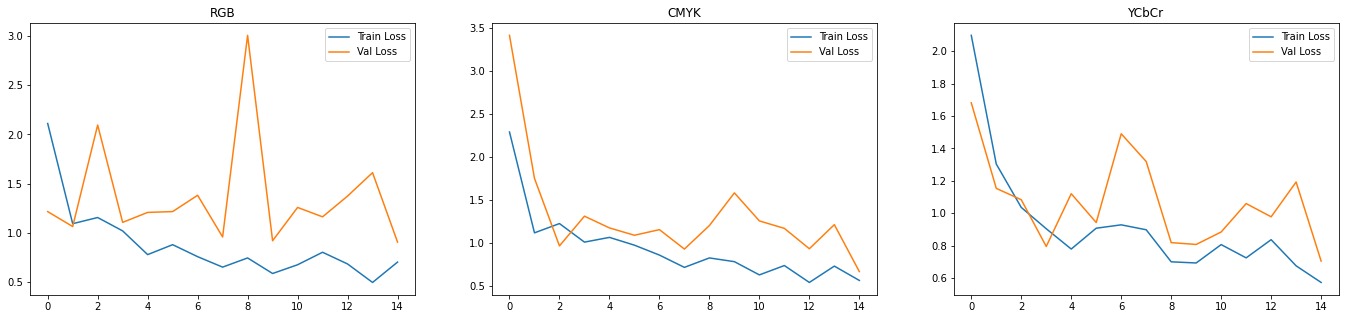

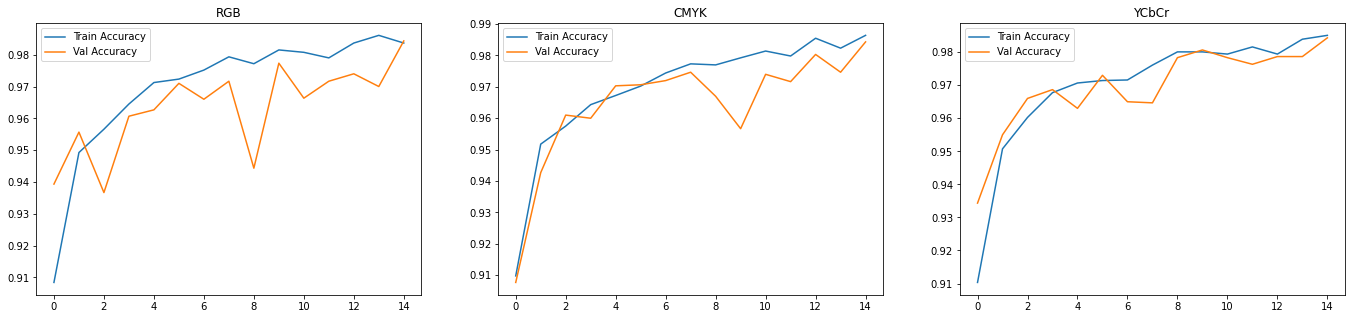

In [26]:
plt.figure(figsize=(40,5))
plt.subplot(1, 5, 1)
plt.title('RGB')
plt.plot(r1.history['loss'], label='Train Loss')
plt.plot(r1.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 5, 2)
plt.title('CMYK')
plt.plot(r2.history['loss'], label='Train Loss')
plt.plot(r2.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 5, 3)
plt.title('YCbCr')
plt.plot(r3.history['loss'], label='Train Loss')
plt.plot(r3.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()
plt.figure(figsize=(40,5))
plt.subplot(1, 5, 1)
plt.title('RGB')
plt.plot(r1.history['accuracy'], label='Train Accuracy')
plt.plot(r1.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1, 5, 2)
plt.title('CMYK')
plt.plot(r2.history['accuracy'], label='Train Accuracy')
plt.plot(r2.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1, 5, 3)
plt.title('YCbCr')
plt.plot(r3.history['accuracy'], label='Train Accuracy')
plt.plot(r3.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.models import load_model
model1.save('nasnetlargergb.h5')
model2.save('nasnetlargecmyk.h5')
model3.save('nasnetlargeycbcr.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
y_pred1 = model1.predict(test_set1)
y_pred11 = np.argmax(y_pred1, axis=1)
y_pred2 = model2.predict(test_set2)
y_pred22 = np.argmax(y_pred2, axis=1)
y_pred3 = model3.predict(test_set3)
y_pred33 = np.argmax(y_pred3, axis=1)

In [29]:
y1 = test_set1.classes
y2 = test_set2.classes
y3 = test_set3.classes

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y1 = y1.reshape((3000, 1))
y_r = encoder.fit_transform(y1)

encoder = OneHotEncoder(sparse=False)
y2 = y2.reshape((3000, 1))
y_c = encoder.fit_transform(y2)

encoder = OneHotEncoder(sparse=False)
y3 = y3.reshape((3000, 1))
y_y = encoder.fit_transform(y3)

In [31]:
y_train = np.concatenate((y_pred1, y_pred2, y_pred3))
y_label = np.concatenate((y_r, y_c, y_y))

In [32]:
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Xtrain, Xtest, y_tr, y_test = train_test_split(y_train, y_label, stratify = y_label, random_state = 0, train_size = 0.7)
print(y_tr.shape, y_test.shape)


knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(Xtrain, y_tr)
y_pred = knn.predict(Xtest)

print(accuracy_score(y_test, y_pred, normalize=False))
print(classification_report(y_test, y_pred))

(6300, 3) (2700, 3)
916
              precision    recall  f1-score   support

           0       0.33      0.03      0.06       900
           1       0.35      0.32      0.33       900
           2       0.34      0.66      0.45       900

   micro avg       0.34      0.34      0.34      2700
   macro avg       0.34      0.34      0.28      2700
weighted avg       0.34      0.34      0.28      2700
 samples avg       0.34      0.34      0.34      2700



In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
  
Xtrain, Xtest, y_tr, y_test = train_test_split(y_train, y_label, stratify = y_label, random_state = 0, train_size = 0.7)
  
# Obtain scores from learning curve function
# cv is the number of folds while performing Cross Validation
sizes, training_scores, testing_scores = learning_curve(KNeighborsClassifier(), Xtrain, y_tr, cv=10, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))

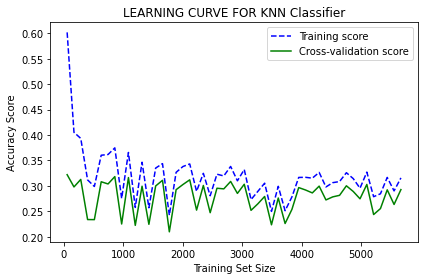

In [34]:
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("LEARNING CURVE FOR KNN Classifier")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [35]:
fpr, tpr, threshold = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

ValueError: multilabel-indicator format is not supported

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

In [38]:
cnf_matrix4 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(40,5))
plt.title('kNN')
plot_confusion_matrix(cnf_matrix4, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')

ValueError: multilabel-indicator is not supported

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

Y_pred1 = model1.predict(test_set1)
y_pred1 = np.argmax(Y_pred1, axis=1)
print(accuracy_score(test_set1.classes, y_pred1))
print(classification_report(test_set1.classes, y_pred1))

In [ ]:
from sklearn.metrics import classification_report

Y_pred2 = model2.predict(test_set2)
y_pred2 = np.argmax(Y_pred2, axis=1)
print(classification_report(test_set2.classes, y_pred2))

In [ ]:
from sklearn.metrics import classification_report

Y_pred3 = model3.predict(test_set3)
y_pred3 = np.argmax(Y_pred3, axis=1)

print(classification_report(test_set3.classes, y_pred3))

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

In [ ]:
cnf_matrix1 = confusion_matrix(test_set1.classes, y_pred1)
cnf_matrix2 = confusion_matrix(test_set2.classes, y_pred2)
cnf_matrix3 = confusion_matrix(test_set3.classes, y_pred3)
np.set_printoptions(precision=2)
plt.figure(figsize=(40,5))
plt.subplot(1,5,1)
plt.title('RGB')
plot_confusion_matrix(cnf_matrix1, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.subplot(1,5,2)
plt.title('CMYK')
plot_confusion_matrix(cnf_matrix2, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.subplot(1,5,3)
plt.title('YCbCr')
plot_confusion_matrix(cnf_matrix3, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
img_size = (299, 299)

last_conv_layer_name = "normal_concat_18"
img_rgb = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn4125.jpeg"
img_cmyk = "../working/cmyk/lung_n/lungn3988.jpeg"
img_ycbcr = "../working/cmyk/lung_n/lungn3988.jpeg"

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
img_rgb_array = preprocess_input(get_img_array(img_rgb, size=img_size))
img_cmyk_array = preprocess_input(get_img_array(img_cmyk, size=img_size))
img_ycbcr_array = preprocess_input(get_img_array(img_ycbcr, size=img_size))

# Make model
model_rgb = keras.model.load_model('nasnetlargergb.h5')
model_cmyk = keras.model.load_model('nasnetlargecmyk.h5')
model_ycbcr = keras.model.load_model('nasnetlargeycbcr.h5')


# Remove last layer's softmax
model_rgb.layers[-1].activation = None
model_cmyk.layers[-1].activation = None
model_ycbcr.layers[-1].activation = None

# Print what the top predicted class is
preds_rgb = model_rgb.predict(img_rgb_array)
preds_cmyk = model_rgb.predict(img_cmyk_array)
preds_ycbcr = model_rgb.predict(img_ycbcr_array)
print("Predicted:", decode_predictions(preds_rgb, top=1)[0])
print("Predicted:", decode_predictions(preds_cmyk, top=1)[0])
print("Predicted:", decode_predictions(preds_ycbcr, top=1)[0])
heatmap_rgb = make_gradcam_heatmap(img_rgb, model, last_conv_layer_name)
plt.matshow(heatmap_rgb)
heatmap_cmyk = make_gradcam_heatmap(img_cmyk, model, last_conv_layer_name)
plt.matshow(heatmap_cmyk)
heatmap_ycbcr = make_gradcam_heatmap(img_ycbcr, model, last_conv_layer_name)
plt.matshow(heatmap_ycbcr)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))
    

save_and_display_gradcam(img_rgb, heatmap_rgb)
save_and_display_gradcam(img_cmyk, heatmap_cmyk)
save_and_display_gradcam(img_ycbcr, heatmap_ycbcr)